**Objective of this notebook:**

1) To try out various state-of-the-art Convolution Models:
   * EfficientNetV2M with top layers replaced by Convolutional Blocks
   * Inception_ResNet_V2
   * NasNetLarge
   * XCeption
   * Inception_V3
   * EfficientNetV2M with Global Average
   * Inception_V3 with Global Average
  

2) To try out ensemble of Convolution Models
   * ensemble of EfficientNetV2M, Inception_ResNet_V2, NasNet & XCeption
   * ensemble of EfficientNetV2M, Inception_ResNet_V2, NasNet, XCeption and   Inception_V3
   * ensemble of EfficientNetV2M, Inception_ResNet_V2, NasNet, XCeption and   Inception_V3 with 50% dropout
   * ensemble of various EfficientNet models with 50% dropout


3) To generate kaggle submission files for each standalone and ensemble models 

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!cp /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/dog-breed-identification.zip /content/

In [ ]:
!unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score,classification_report

import cv2
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,Dense,BatchNormalization,Flatten,Concatenate, Dropout,MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

from prettytable import PrettyTable

In [ ]:
kaggle_file_dir = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/KaggleSubmission/"

In [ ]:
#read csv file having the training image 'file name' and its 'breed category'
train_df = pd.read_csv("/content/labels.csv")

#convert breed to numeric values
unique_breeds = list(pd.unique(train_df["breed"]))
unique_breeds_map = {breed:ind for ind,breed in enumerate(unique_breeds)}
unique_breeds_reversemap = {ind:breed for breed,ind in unique_breeds_map.items()}
train_df["breed_id"] = train_df["breed"].map(unique_breeds_map) 

Get spatial dimensions of the training images

In [ ]:
dir="train"
img_names = train_df["id"] + ".jpg"
height = []
width = []

for img in img_names:
  image = cv2.imread(os.path.join(dir,img))
  h,w,c = image.shape
  height.append(h)
  width.append(w)

train_df["height"] = height
train_df["width"] = width
train_df["aspect_ratio"] = train_df["height"] / train_df["width"]  

Remove out-of-proportion images identified in EDA using aspect ratio.

In [ ]:
train_df = train_df.loc[(train_df["aspect_ratio"] > 0.5) & (train_df["aspect_ratio"] < 2.3)]
train_df.shape

(10199, 6)

Collect the path, labels of training images

In [ ]:
train_dir = "train"
train_image_dir = os.path.join(os.getcwd(),train_dir)+os.sep
paths = train_image_dir + train_df["id"] + ".jpg"
labels = train_df["breed_id"].values
num_classes =  train_df["breed_id"].nunique()

Split the images between training and validation data

In [ ]:
val_percent = 0.2
train_percent = 1-val_percent
train_paths,val_paths, train_label,val_label = train_test_split(paths,labels,test_size=val_percent,stratify=labels)
train_size = train_paths.shape[0]
val_size = val_paths.shape[0]

Build input pipeline using the pathnames and labels

In [ ]:
resize_height = 350
resize_width  = 350
batch_size = 32

In [ ]:
def load_images_test(imagePath,istrain=True):
	# read the image from disk, decode it and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.resize(image, [resize_height,resize_width])
	return image

In [ ]:
def load_images(imagePath,label,istrain=True):
	# read the image from disk, decode it and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.resize(image, [resize_height,resize_width])
	
	#Convert label into one hot encoding since we need to output probabilities for all classes
	label = tf.one_hot(tf.cast(label, tf.uint8), num_classes)
	return (image, label)

Data Augmentation using Keras Preprocessing Layers

https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
def configure_for_performance(ds,istrain=True,istest=False):
  if istrain:
    ds = ds.cache('/content/train_cache')  #since training data is huge, use disk space to cache the data
    ds = ds.shuffle(buffer_size=500)       #reduced buffer size to avoid out of memory errors

  elif istest:
    ds = ds.cache('/content/test_cache')   #use cache on disk
  
  else:
    ds = ds.cache('')         #use RAM memory to cache the validation data as it is relatively very small
    ds = ds.shuffle(buffer_size=100)


  ds = ds.batch(batch_size)
  
  # Use data augmentation only on the training set.
  if istrain:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
#Image Augmentation using Keras Preprocessing layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(mode='horizontal'),
  layers.RandomRotation(0.2,fill_mode='constant'),
  layers.RandomZoom(0.1, 0.1,fill_mode='constant'),
  layers.RandomTranslation(0, 0.2)
])

###Optional Section to see how data augmentation techniques produces images

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
train_ds = train_ds.shuffle(train_size).map(load_images,num_parallel_calls=AUTOTUNE)

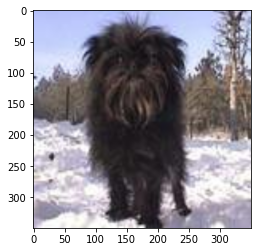

In [ ]:
image, label = next(iter(train_ds))
image = tf.cast(image,tf.float32)/255.0
_ = plt.imshow(image)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [ ]:
#Check how the augmentation techniques work
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image,training=True)
  plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  

###Continue with Input Pipeline

In [ ]:
#shutil.rmtree('train_cache')
os.makedirs("train_cache")

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_label))

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8159
2040


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_label))

train_ds = train_ds.shuffle(train_size).map(load_images,num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds,istrain=True,istest=False)

val_ds = val_ds.shuffle(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
val_ds = configure_for_performance(val_ds,istrain=False,istest=False)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

255
64


In [ ]:
for image, label in train_ds.take(1): #use 1 batch
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 350, 350, 3)
Label:  (32, 120)


### Get input pipeline for the test directory

In [ ]:
#shutil.rmtree("test_cache")
os.makedirs("test_cache")

In [ ]:
test_paths = pd.DataFrame(os.listdir("test"),columns=["test_path"])
test_paths_l = [os.path.join("test",path) for path in test_paths["test_path"]]
test_ds = tf.data.Dataset.from_tensor_slices(test_paths_l)
test_ds = test_ds.map(load_images_test,num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds,istrain=False,istest=True)

Process test predictions from model

In [ ]:
def process_test_pred(test_pred, csv_name="test_sub.csv"):
  # 1. Identify the class with the maximum probability

  #Convert one-hot vector to integer variable
  test_pred_label = np.argmax(test_pred, axis=1)
  test_pred_label_arr = test_pred_label
  test_paths["pred_breed_id"] = test_pred_label_arr
  #Convert integer variable to categorical variable
  test_paths["pred_breed"] =  test_paths["pred_breed_id"].map(unique_breeds_reversemap)

  # 2. Populate the probabilities for all classes to the dataframe
  out_cols = list(unique_breeds_reversemap.values())
  test_paths[out_cols] = test_pred

  # 3. Process files for kaggle submission format
  test_paths["test_path"] = test_paths["test_path"].str.split('.jpg').str[0]
  out_cols.sort()
  order_cols = ['test_path'] + out_cols
  test_sub = test_paths[order_cols]
  test_sub.rename(columns={"test_path":"id"},inplace=True)
  test_sub.to_csv(csv_name,index=False)

###Model#1  - EfficientNetV2M

In [ ]:
def build_model1():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  #use the pretrained ResNet model
  base_model = EfficientNetV2M(weights="imagenet", include_top=False)(inputs)

  #Conv Block
  TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  MaxPool1 = MaxPooling2D((2,2))(TopConv1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(FC1)

  effnet_model = Model(inputs=inputs, outputs=output)
  return effnet_model

In [ ]:
#build the model
effnet_model1 = build_model1()

#set the layers of the resnet pretrained model as non-trainable
for layer in effnet_model1.layers[1].layers:   #-7 #-4
  layer.trainable = False

#compile the model

effnet_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(effnet_model1.summary())

214212608/214201816 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, None, None, 1280)  53150388 
 l)                                                              
                                                                 
 newtopC1 (Conv2D)           (None, 9, 9, 128)         1474688   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                            

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet1"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet1"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet1"
local_ckpt_path = os.path.join(checkpoint_dir, 'resnet1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'effnet1', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=8, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = effnet_model1.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.4638 - accuracy: 0.5199
Epoch 1: val_accuracy improved from -inf to 0.90392, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet1/resnet1.h5
255/255 [==============================] - 301s 1s/step - loss: 2.4638 - accuracy: 0.5199 - val_loss: 0.5301 - val_accuracy: 0.9039 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.8416
Epoch 2: val_accuracy improved from 0.90392 to 0.91863, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet1/resnet1.h5
255/255 [==============================] - 267s 1s/step - loss: 0.7325 - accuracy: 0.8416 - val_loss: 0.3398 - val_accuracy: 0.9186 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.8660
Epo

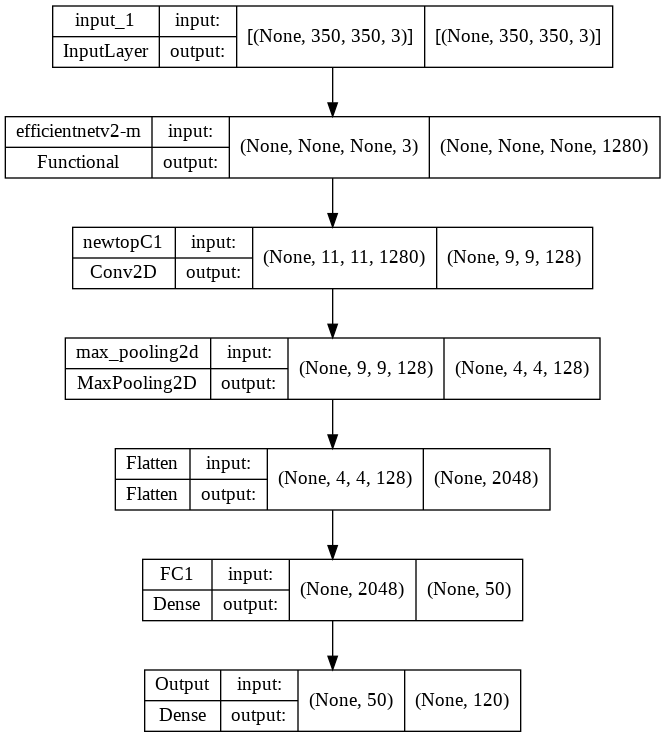

In [ ]:
tf.keras.utils.plot_model(
    effnet_model1, to_file='effnet_model1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
effnet_model1.load_weights(local_ckpt_path)

In [ ]:
test_pred = effnet_model1.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_EfficientNet.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


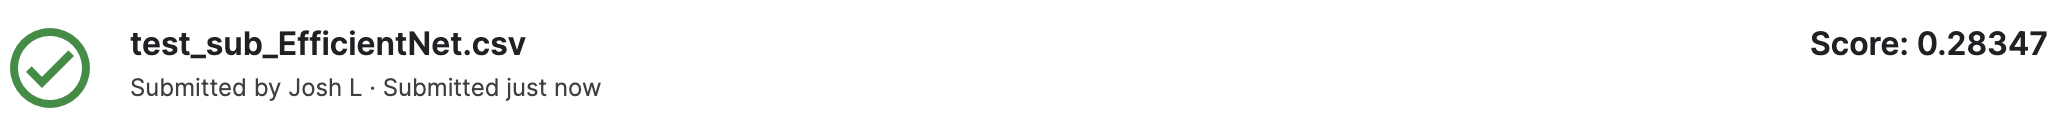

###Model#2  - Inception_ResNet_V2

In [ ]:
def build_model2():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  inputs = tf.cast(inputs, tf.float32)

  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)  

  #use the pretrained ResNet model
  base_model = InceptionResNetV2(weights="imagenet", include_top=False)(processed_inputs)

  #Conv Block
  TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  MaxPool1 = layers.MaxPooling2D((2,2))(TopConv1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(FC1)

  inception_resnet_model = Model(inputs=inputs, outputs=output)
  return inception_resnet_model

In [ ]:
#build the model
inception_resnet_model2 = build_model2()

#set the layers of the resnet pretrained model as non-trainable
for layer in inception_resnet_model2.layers[3].layers:   #-7 #-4
  layer.trainable = False

#compile the model

inception_resnet_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(inception_resnet_model2.summary())

219070464/219055592 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 350, 350, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 350, 350, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 newtopC1 (Conv2D)           (None, 7, 7, 128)         17696

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_incresnet2"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_incresnet2"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_incresnet2"
local_ckpt_path = os.path.join(checkpoint_dir, 'inceptionresnet.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'incresnet2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = inception_resnet_model2.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.8436 - accuracy: 0.4189
Epoch 1: val_accuracy improved from -inf to 0.86912, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_incresnet2/resnet2.h5
255/255 [==============================] - 277s 1s/step - loss: 2.8436 - accuracy: 0.4189 - val_loss: 0.7137 - val_accuracy: 0.8691 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.7147
Epoch 2: val_accuracy improved from 0.86912 to 0.89755, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_incresnet2/resnet2.h5
255/255 [==============================] - 262s 1s/step - loss: 1.3395 - accuracy: 0.7147 - val_loss: 0.4257 - val_accuracy: 0.8975 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 1.0464 - accuracy: 0.75

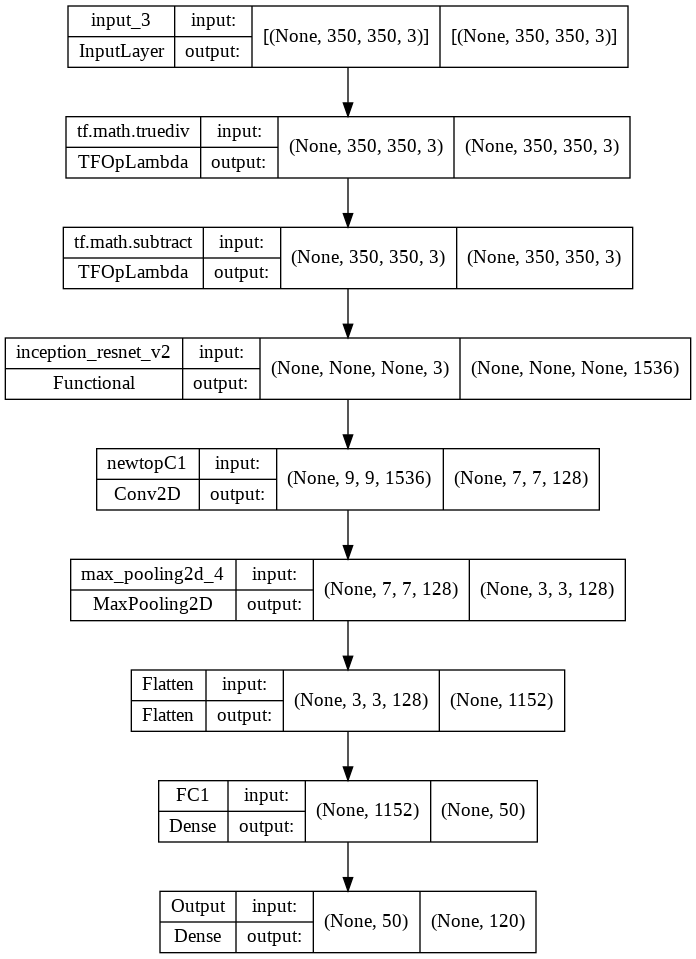

In [ ]:
tf.keras.utils.plot_model(
    inception_resnet_model2, to_file='inception_resnet_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
inception_resnet_model2.load_weights(local_ckpt_path)

In [ ]:
test_pred = inception_resnet_model2.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_InceptionResNet.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


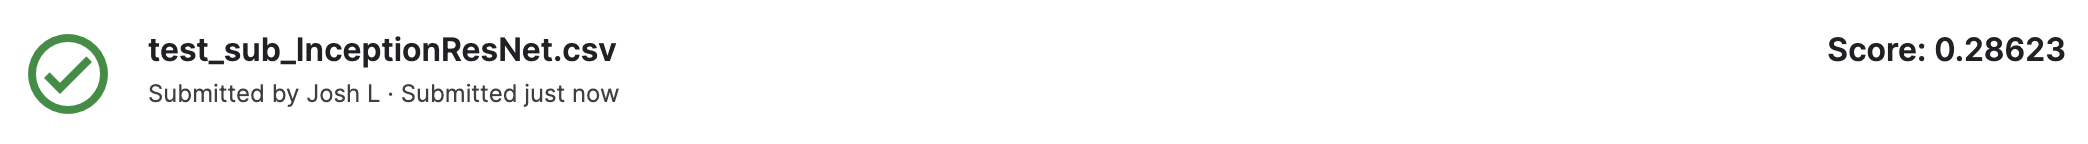

###Model#3: NASNetLarge

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge 

In [ ]:
def build_model3():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  inputs = tf.cast(inputs, tf.float32)
  inputs_resized = tf.keras.layers.Resizing(331, 331)(inputs)


  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = tf.keras.applications.nasnet.preprocess_input(inputs_resized)  

  #use the pretrained ResNet model
  base_model = NASNetLarge(input_shape=(331,331,3),weights="imagenet", include_top=False)(processed_inputs)

  #Conv Block
  TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  MaxPool1 = layers.MaxPooling2D((2,2))(TopConv1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(FC1)

  nasnet_model = Model(inputs=inputs, outputs=output)
  return nasnet_model

In [ ]:
#build the model
nasnet_model = build_model3()

#set the layers of the resnet pretrained model as non-trainable
for layer in nasnet_model.layers[4].layers:   #-7 #-4
  layer.trainable = False

#compile the model

nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(nasnet_model.summary())

343621632/343610240 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 331, 331, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 331, 331, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 331, 331, 3)      0         
 a)                                                              
                                                                 
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                            

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_nasnet"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_nasnet"

removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_nasnet'


In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_nasnet"
local_ckpt_path = os.path.join(checkpoint_dir, 'nasnet.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'nasnet', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = nasnet_model.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.0380 - accuracy: 0.5791
Epoch 1: val_accuracy improved from -inf to 0.90098, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_nasnet/nasnet.h5
255/255 [==============================] - 354s 1s/step - loss: 2.0380 - accuracy: 0.5791 - val_loss: 0.4300 - val_accuracy: 0.9010 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.7709
Epoch 2: val_accuracy improved from 0.90098 to 0.91176, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_nasnet/nasnet.h5
255/255 [==============================] - 335s 1s/step - loss: 1.0443 - accuracy: 0.7709 - val_loss: 0.3837 - val_accuracy: 0.9118 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 0.8810 - accuracy: 0.7916
Epoch 3

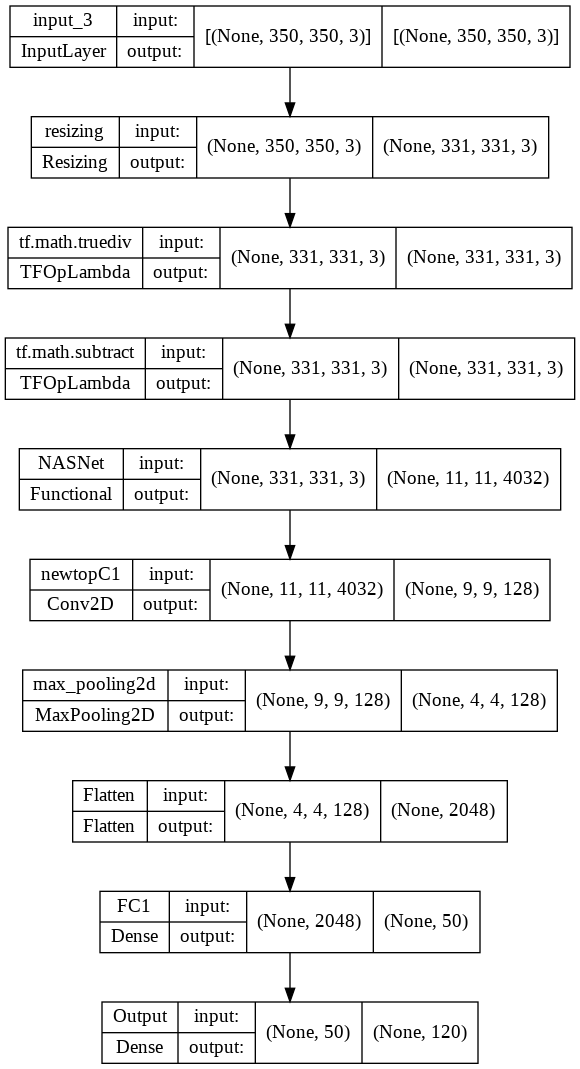

In [ ]:
tf.keras.utils.plot_model(
    nasnet_model, to_file='nasnet_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
nasnet_model.load_weights(local_ckpt_path)

In [ ]:
test_pred = nasnet_model.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_Nasnet.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


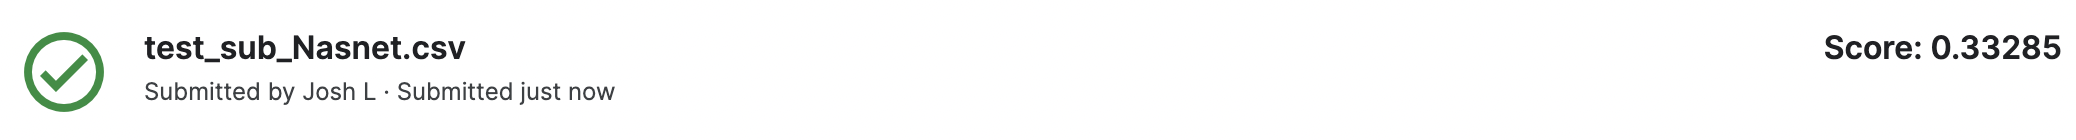

###Model#4: Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception 

In [ ]:
def build_model4():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  inputs = tf.cast(inputs, tf.float32)
  #inputs_resized = tf.keras.layers.Resizing(331, 331)(inputs)


  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = tf.keras.applications.xception.preprocess_input(inputs)  

  #use the pretrained ResNet model
  base_model = Xception(weights="imagenet", include_top=False)(processed_inputs)

  #Conv Block
  TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  MaxPool1 = layers.MaxPooling2D((2,2))(TopConv1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(FC1)

  xception_model = Model(inputs=inputs, outputs=output)
  return xception_model

In [ ]:
#build the model
xception_model = build_model4()

#set the layers of the resnet pretrained model as non-trainable
for layer in xception_model.layers[3].layers:   #-7 #-4
  layer.trainable = False

#compile the model

xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(xception_model.summary())

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 350, 350, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 350, 350, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 newtopC1 (Conv2D)           (None, 9, 9, 128)         2359424   
                                                              

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_xception"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_xception"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_xception"
local_ckpt_path = os.path.join(checkpoint_dir, 'xception.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'xception', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = xception_model.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 3.0924 - accuracy: 0.3369
Epoch 1: val_accuracy improved from -inf to 0.80049, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_xception/nasnet.h5
255/255 [==============================] - 237s 898ms/step - loss: 3.0924 - accuracy: 0.3369 - val_loss: 0.9124 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 1.4654 - accuracy: 0.6536
Epoch 2: val_accuracy improved from 0.80049 to 0.86225, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_xception/nasnet.h5
255/255 [==============================] - 235s 906ms/step - loss: 1.4654 - accuracy: 0.6536 - val_loss: 0.5110 - val_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 1.1484 - accuracy: 0.71

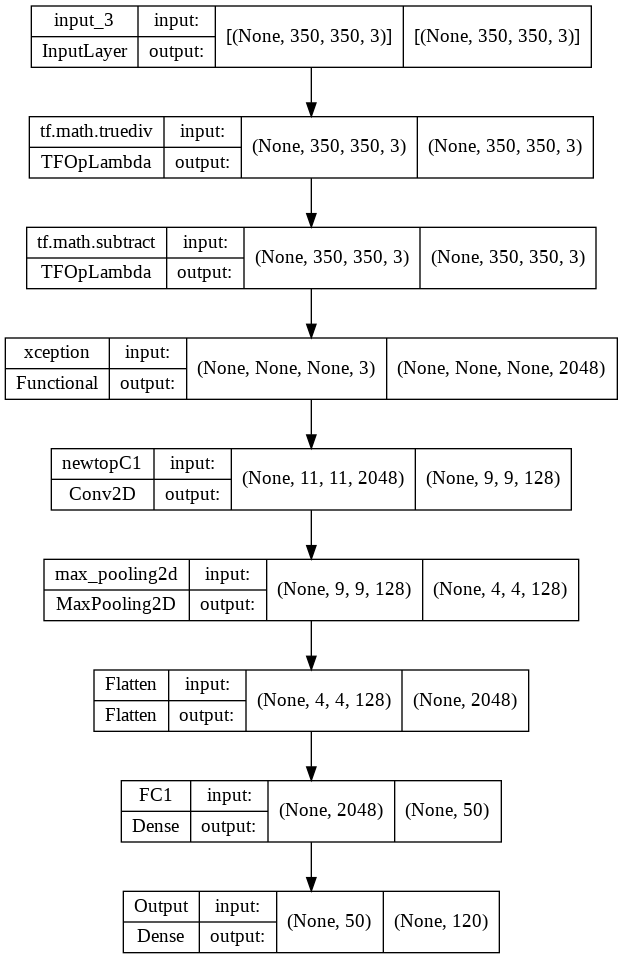

In [ ]:
tf.keras.utils.plot_model(
    xception_model, to_file='xception_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
xception_model.load_weights(local_ckpt_path)

In [ ]:
test_pred = xception_model.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_Xception.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


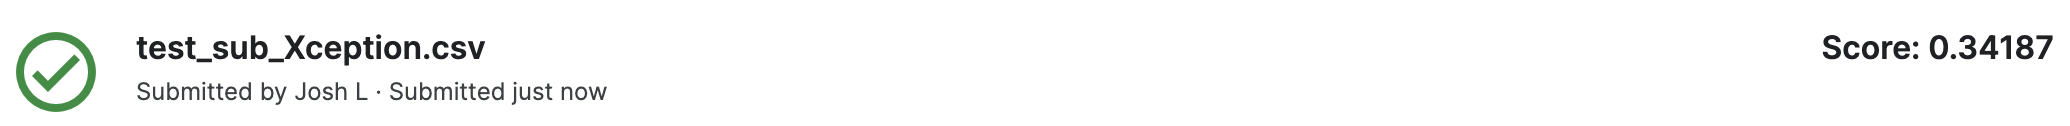

###Model#5: InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 

In [ ]:
def build_model5():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  inputs = tf.cast(inputs, tf.float32)
  #inputs_resized = tf.keras.layers.Resizing(331, 331)(inputs)


  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = tf.keras.applications.inception_v3.preprocess_input(inputs)  

  #use the pretrained ResNet model
  base_model = InceptionV3(weights="imagenet", include_top=False)(processed_inputs)

  #Conv Block
  TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  MaxPool1 = layers.MaxPooling2D((2,2))(TopConv1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(FC1)

  inception_model = Model(inputs=inputs, outputs=output)
  return inception_model

In [ ]:
#build the model
inception_model = build_model5()

#set the layers of the resnet pretrained model as non-trainable
for layer in inception_model.layers[3].layers:   #-7 #-4
  layer.trainable = False

#compile the model

inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(inception_model.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 350, 350, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 350, 350, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 newtopC1 (Conv2D)           (None, 7, 7, 128)         2359424   
                                                              

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception"
local_ckpt_path = os.path.join(checkpoint_dir, 'inception.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'inception', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = inception_model.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 3.6191 - accuracy: 0.2301
Epoch 1: val_accuracy improved from -inf to 0.66275, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception/inception.h5
255/255 [==============================] - 233s 875ms/step - loss: 3.6191 - accuracy: 0.2301 - val_loss: 1.5485 - val_accuracy: 0.6627 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 1.9456 - accuracy: 0.5457
Epoch 2: val_accuracy improved from 0.66275 to 0.81520, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception/inception.h5
255/255 [==============================] - 227s 874ms/step - loss: 1.9456 - accuracy: 0.5457 - val_loss: 0.7455 - val_accuracy: 0.8152 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 1.4900 - accura

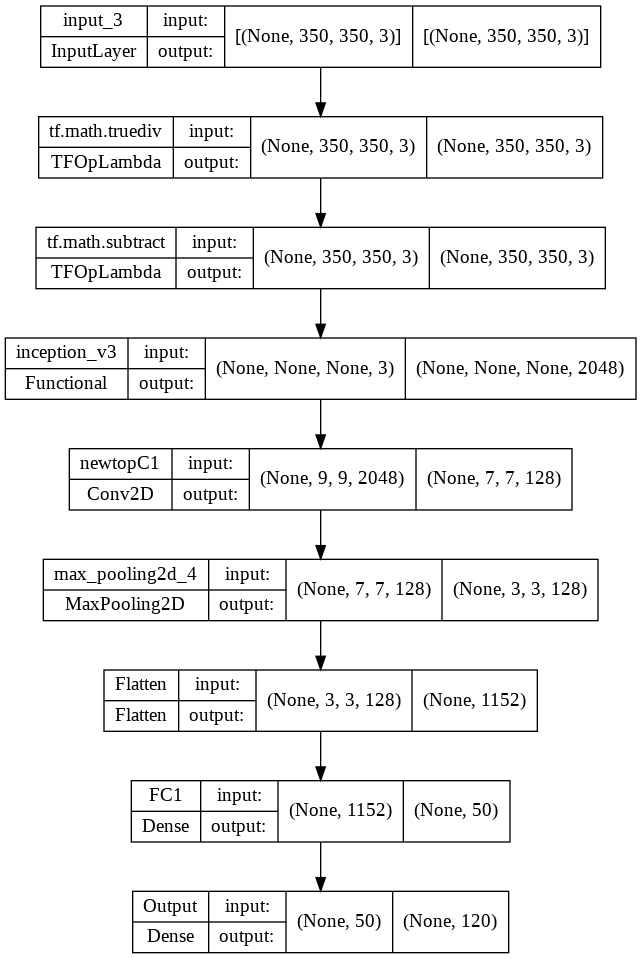

In [ ]:
tf.keras.utils.plot_model(
    inception_model, to_file='inception_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
inception_model.load_weights(local_ckpt_path)

In [ ]:
test_pred = inception_model.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_Inception.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


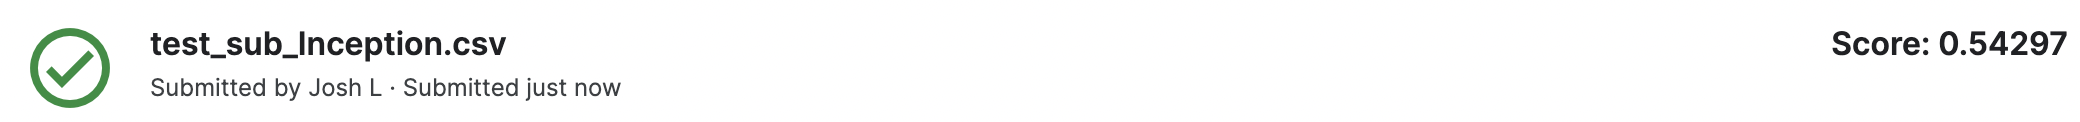

###Model#6  - EfficientNetV2M + Global Avg 

In [ ]:
def build_model6():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  #use the pretrained ResNet model
  base_model = EfficientNetV2M(weights="imagenet", include_top=False,pooling='avg')(inputs)

  #Conv Block
  #TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  #MaxPool1 = layers.MaxPooling2D((2,2))(TopConv1)

  #Flatten
  #flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  #FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)
                                 
  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(base_model)

  effnet_model = Model(inputs=inputs, outputs=output)
  return effnet_model

In [ ]:
#build the model
effnet_model2 = build_model6()

#set the layers of the resnet pretrained model as non-trainable
for layer in effnet_model2.layers[1].layers:   #-7 #-4
  layer.trainable = False

#compile the model

effnet_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(effnet_model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 Output (Dense)              (None, 120)               153720    
                                                                 
Total params: 53,304,108
Trainable params: 153,720
Non-trainable params: 53,150,388
_________________________________________________________________
None


In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet2"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet2"

removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet2'


In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet2"
local_ckpt_path = os.path.join(checkpoint_dir, 'effnet2.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'effnet2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=8, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = effnet_model2.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.2629 - accuracy: 0.4132
Epoch 1: val_accuracy improved from -inf to 0.84559, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet2/effnet2.h5
255/255 [==============================] - 311s 1s/step - loss: 4.2629 - accuracy: 0.4132 - val_loss: 3.6829 - val_accuracy: 0.8456 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 3.2024 - accuracy: 0.8268
Epoch 2: val_accuracy improved from 0.84559 to 0.92206, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_effnet2/effnet2.h5
255/255 [==============================] - 274s 1s/step - loss: 3.2024 - accuracy: 0.8268 - val_loss: 2.6678 - val_accuracy: 0.9221 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 2.2955 - accuracy: 0.8630
Epo

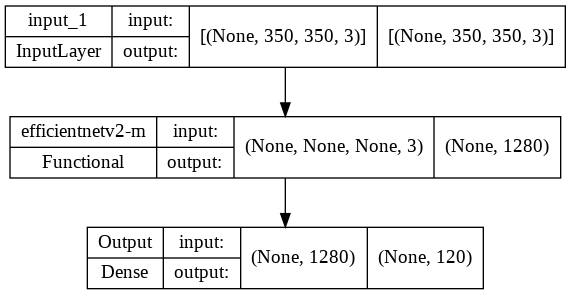

In [ ]:
tf.keras.utils.plot_model(
    effnet_model2, to_file='effnet_model2.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
effnet_model2.load_weights(local_ckpt_path)

In [ ]:
test_pred = effnet_model2.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_EfficientNet_GlobalAvg.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


image.png

###Model#7: InceptionV3 + Global Avg Pooling

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 

In [ ]:
def build_model7():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  inputs = tf.cast(inputs, tf.float32)
  #inputs_resized = tf.keras.layers.Resizing(331, 331)(inputs)


  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = tf.keras.applications.inception_v3.preprocess_input(inputs)  

  #use the pretrained ResNet model
  base_model = InceptionV3(weights="imagenet", include_top=False,pooling='avg')(processed_inputs)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(base_model)

  inception_model = Model(inputs=inputs, outputs=output)
  return inception_model

In [ ]:
#build the model
inception_model = build_model7()

#set the layers of the resnet pretrained model as non-trainable
for layer in inception_model.layers[3].layers:   #-7 #-4
  layer.trainable = False

#compile the model

inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(inception_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 350, 350, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 350, 350, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 Output (Dense)              (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-traina

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception2"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception2"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception2"
local_ckpt_path = os.path.join(checkpoint_dir, 'inception.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'inception2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = inception_model.fit(train_ds,epochs=50,validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.3750 - accuracy: 0.1451
Epoch 1: val_accuracy improved from -inf to 0.49216, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception2/inception.h5
255/255 [==============================] - 247s 895ms/step - loss: 4.3750 - accuracy: 0.1451 - val_loss: 3.7526 - val_accuracy: 0.4922 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 3.4597 - accuracy: 0.4872
Epoch 2: val_accuracy improved from 0.49216 to 0.76078, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_inception2/inception.h5
255/255 [==============================] - 216s 829ms/step - loss: 3.4597 - accuracy: 0.4872 - val_loss: 2.8581 - val_accuracy: 0.7608 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 2.7386 - accu

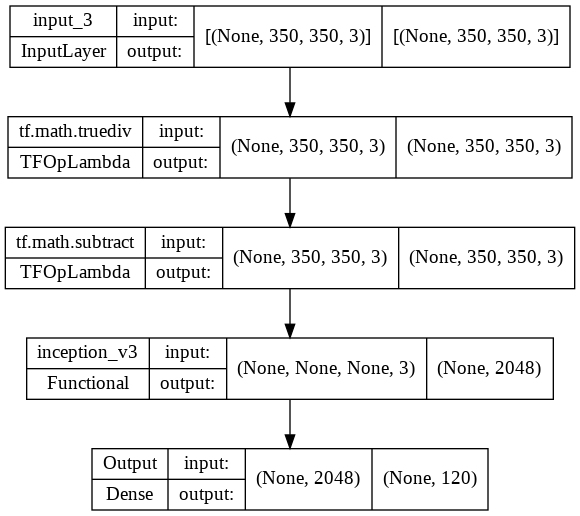

In [ ]:
tf.keras.utils.plot_model(
    inception_model, to_file='inception_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
inception_model.load_weights(local_ckpt_path)

In [ ]:
test_pred = inception_model.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_Inception_GlobalAvg.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


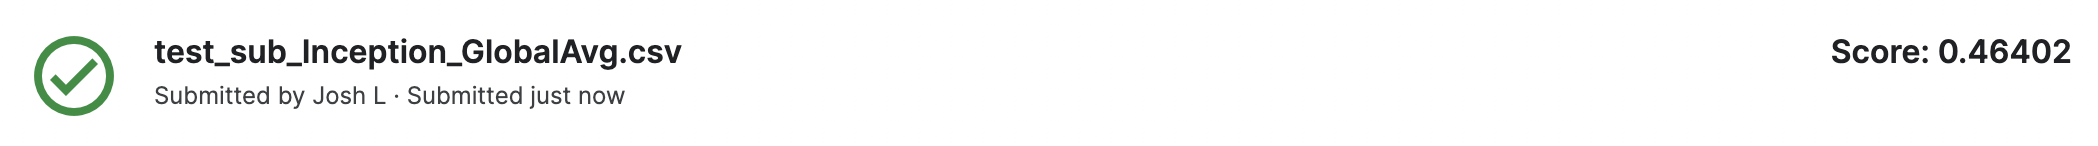

###Ensemble Model#1: Using EfficientNEt, InceptionResNet, NasNet, Xception

In [ ]:
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception 

In [ ]:
def build_ensemble_model():

  tf.keras.backend.clear_session()

  #incoming inputs
  inputs = Input(shape=(resize_height, resize_width, 3))

  #float inputs
  float_inputs = tf.cast(inputs, tf.float32)

  #resized inputs
  inputs_resized = tf.keras.layers.Resizing(331, 331)(float_inputs)

  #preprocessors
  inception_inputs = tf.keras.applications.inception_resnet_v2.preprocess_input(float_inputs) 
  nasnet_inputs    = tf.keras.applications.nasnet.preprocess_input(inputs_resized)  
  xception_inputs = tf.keras.applications.xception.preprocess_input(float_inputs)  

  #pretrained models
  effnet_base          = EfficientNetV2M(weights="imagenet", include_top=False,pooling='avg')(inputs)
  inceptionresnet_base = InceptionResNetV2(weights="imagenet", include_top=False,pooling='avg')(inception_inputs)
  nasnet_base          = NASNetLarge(input_shape=(331,331,3),weights="imagenet", include_top=False,pooling='avg')(nasnet_inputs)
  xception_base        = Xception(weights="imagenet", include_top=False,pooling='avg')(xception_inputs)


  all_features = Concatenate()([effnet_base, inceptionresnet_base, nasnet_base,xception_base])
  #x = Dropout(.7)(x)
  outputs = Dense(num_classes, activation='softmax')(all_features)
  model = Model(inputs, outputs)

  return model

In [ ]:
ensemble_model = build_ensemble_model()

#set the layers of the resnet pretrained model as non-trainable
for layer in ensemble_model.layers[9].layers:   #-7 #-4
  layer.trainable = False

for layer in ensemble_model.layers[10].layers:   #-7 #-4
  layer.trainable = False

for layer in ensemble_model.layers[11].layers:   #-7 #-4
  layer.trainable = False

for layer in ensemble_model.layers[12].layers:   #-7 #-4
  layer.trainable = False

#compile the model

ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(ensemble_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 350, 350, 3)  0           ['input_1[0][0]']                
                                                                                                  
 resizing (Resizing)            (None, 331, 331, 3)  0           ['tf.cast[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 350, 350, 3)  0           ['tf.cast[0][0]']            

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1"

removed '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1/resnet1.h5'
removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1'


In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1"
local_ckpt_path = os.path.join(checkpoint_dir, 'ensemble1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'ensemble1', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1,mode='min')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = ensemble_model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.4292 - accuracy: 0.6849
Epoch 1: val_loss improved from inf to 0.70362, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1/ensemble1.h5
255/255 [==============================] - 553s 2s/step - loss: 2.4292 - accuracy: 0.6849 - val_loss: 0.7036 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.8742
Epoch 2: val_loss improved from 0.70362 to 0.30115, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble1/ensemble1.h5
255/255 [==============================] - 506s 2s/step - loss: 0.6979 - accuracy: 0.8742 - val_loss: 0.3011 - val_accuracy: 0.9436 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8811
Epoc

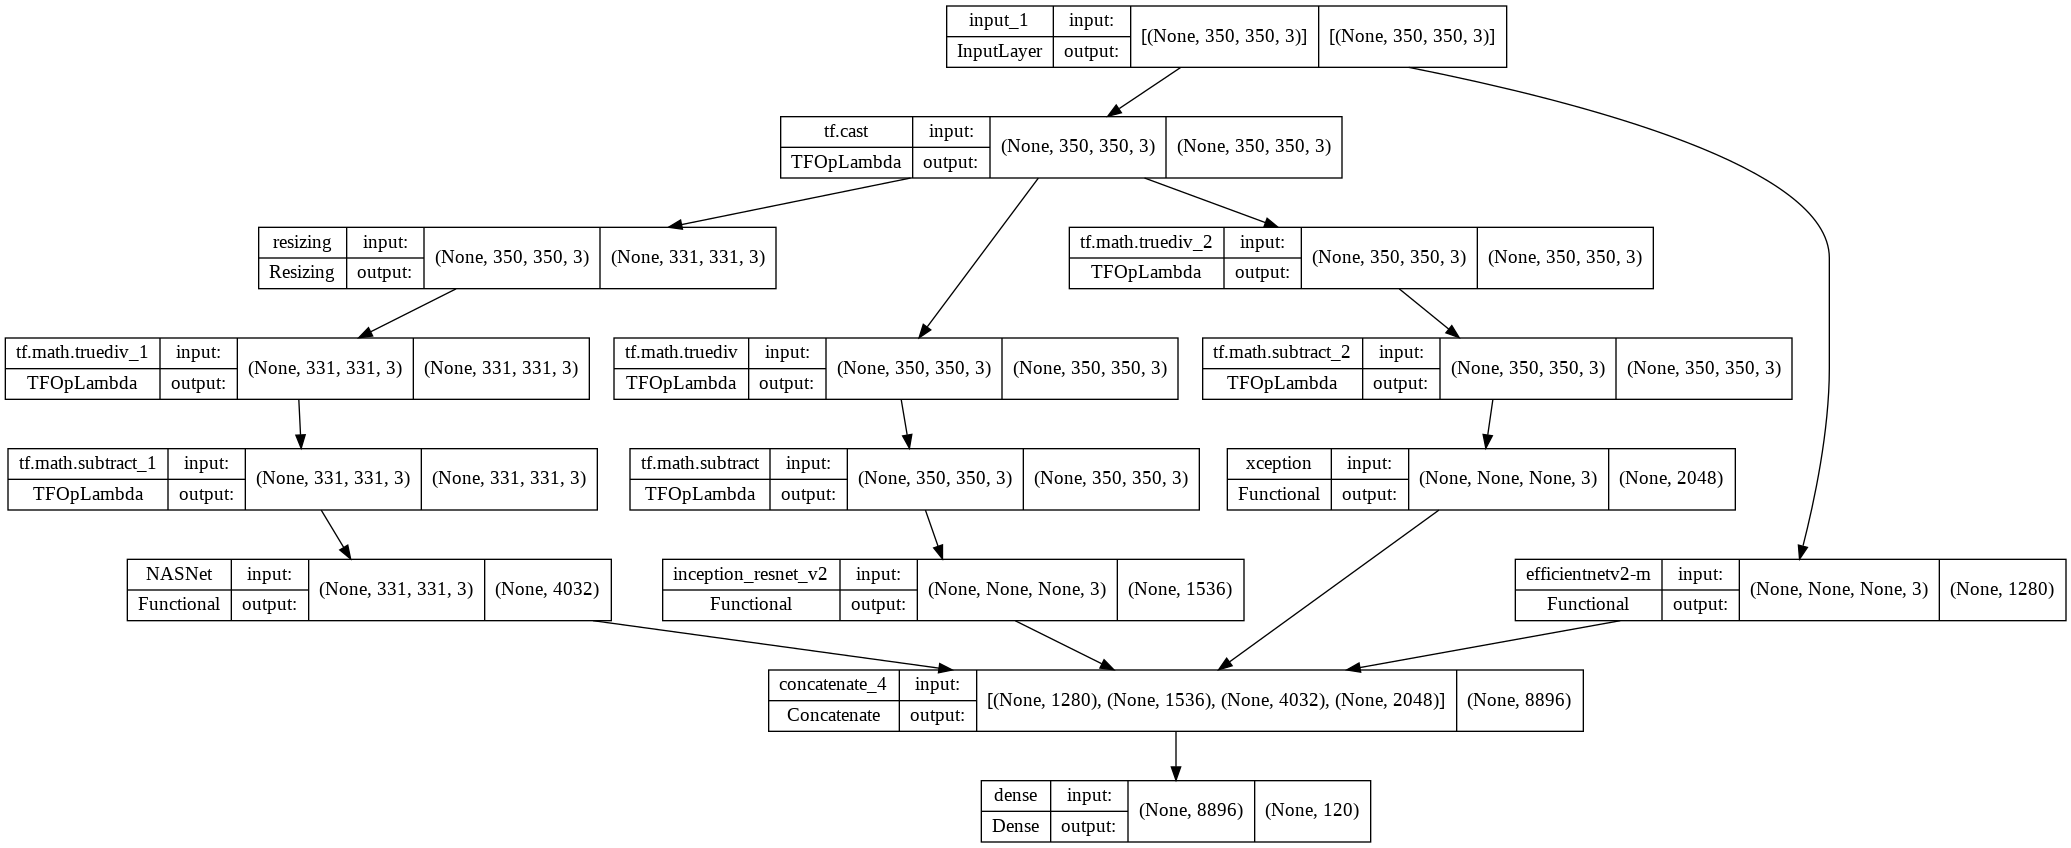

In [ ]:
tf.keras.utils.plot_model(
    ensemble_model, to_file='ensemble_model1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
ensemble_model.load_weights(local_ckpt_path)

In [ ]:
test_pred = ensemble_model.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ConvModelsEnsemble1.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


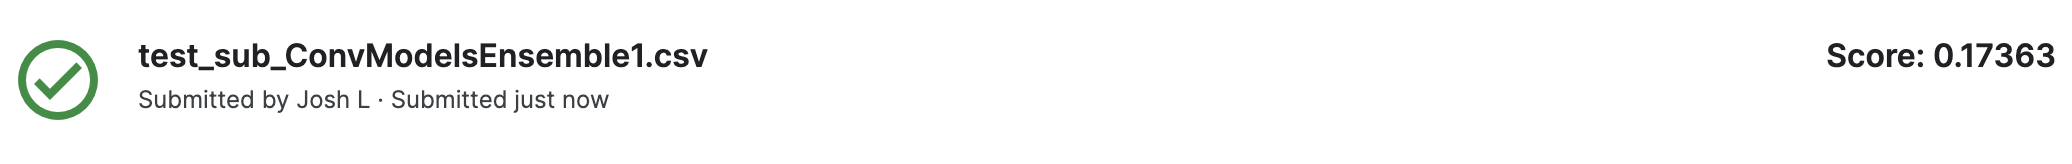

###Ensemble Model#2: Using EfficientNEt, InceptionResNet, NasNet, Xception and InceptionV3

In [ ]:
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception 
from tensorflow.keras.applications.inception_v3 import InceptionV3 

In [ ]:
def build_ensemble_model2():

  tf.keras.backend.clear_session()

  #incoming inputs
  inputs = Input(shape=(resize_height, resize_width, 3))

  #float inputs
  float_inputs = tf.cast(inputs, tf.float32)

  #resized inputs
  inputs_resized = tf.keras.layers.Resizing(331, 331)(float_inputs)

  #preprocessors
  inceptionresnet_inputs = tf.keras.applications.inception_resnet_v2.preprocess_input(float_inputs) 
  nasnet_inputs    = tf.keras.applications.nasnet.preprocess_input(inputs_resized)  
  xception_inputs  = tf.keras.applications.xception.preprocess_input(float_inputs)  
  inception_inputs = tf.keras.applications.inception_v3.preprocess_input(float_inputs)  

  #pretrained models
  effnet_base          = EfficientNetV2M(weights="imagenet", include_top=False,pooling='avg')(inputs)
  inceptionresnet_base = InceptionResNetV2(weights="imagenet", include_top=False,pooling='avg')(inceptionresnet_inputs)
  nasnet_base          = NASNetLarge(input_shape=(331,331,3),weights="imagenet", include_top=False,pooling='avg')(nasnet_inputs)
  xception_base        = Xception(weights="imagenet", include_top=False,pooling='avg')(xception_inputs)
  inception_base       = InceptionV3(weights="imagenet", include_top=False,pooling='avg')(inception_inputs)



  all_features = Concatenate()([effnet_base, inceptionresnet_base, nasnet_base,xception_base,inception_base])
  #x = Dropout(.7)(x)
  outputs = Dense(num_classes, activation='softmax')(all_features)
  model = Model(inputs, outputs)

  return model

In [ ]:
ensemble_model2 = build_ensemble_model2()

#set the layers of the resnet pretrained model as non-trainable
for layer in ensemble_model2.layers[11].layers:  
  layer.trainable = False

for layer in ensemble_model2.layers[12].layers:   
  layer.trainable = False

for layer in ensemble_model2.layers[13].layers:   
  layer.trainable = False

for layer in ensemble_model2.layers[14].layers:   
  layer.trainable = False

for layer in ensemble_model2.layers[15].layers:   
  layer.trainable = False

#compile the model

ensemble_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(ensemble_model2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 350, 350, 3)  0           ['input_1[0][0]']                
                                                                                                  
 resizing (Resizing)            (None, 331, 331, 3)  0           ['tf.cast[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 350, 350, 3)  0           ['tf.cast[0][0]']            

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble2"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble2"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble2"
local_ckpt_path = os.path.join(checkpoint_dir, 'ensemble2.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'ensemble2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1,mode='min')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = ensemble_model2.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.2614 - accuracy: 0.6735
Epoch 1: val_loss improved from inf to 0.60101, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble2/ensemble1.h5
255/255 [==============================] - 687s 2s/step - loss: 2.2614 - accuracy: 0.6735 - val_loss: 0.6010 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.8734
Epoch 2: val_loss improved from 0.60101 to 0.29326, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble2/ensemble1.h5
255/255 [==============================] - 604s 2s/step - loss: 0.6359 - accuracy: 0.8734 - val_loss: 0.2933 - val_accuracy: 0.9392 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8836
Epoc

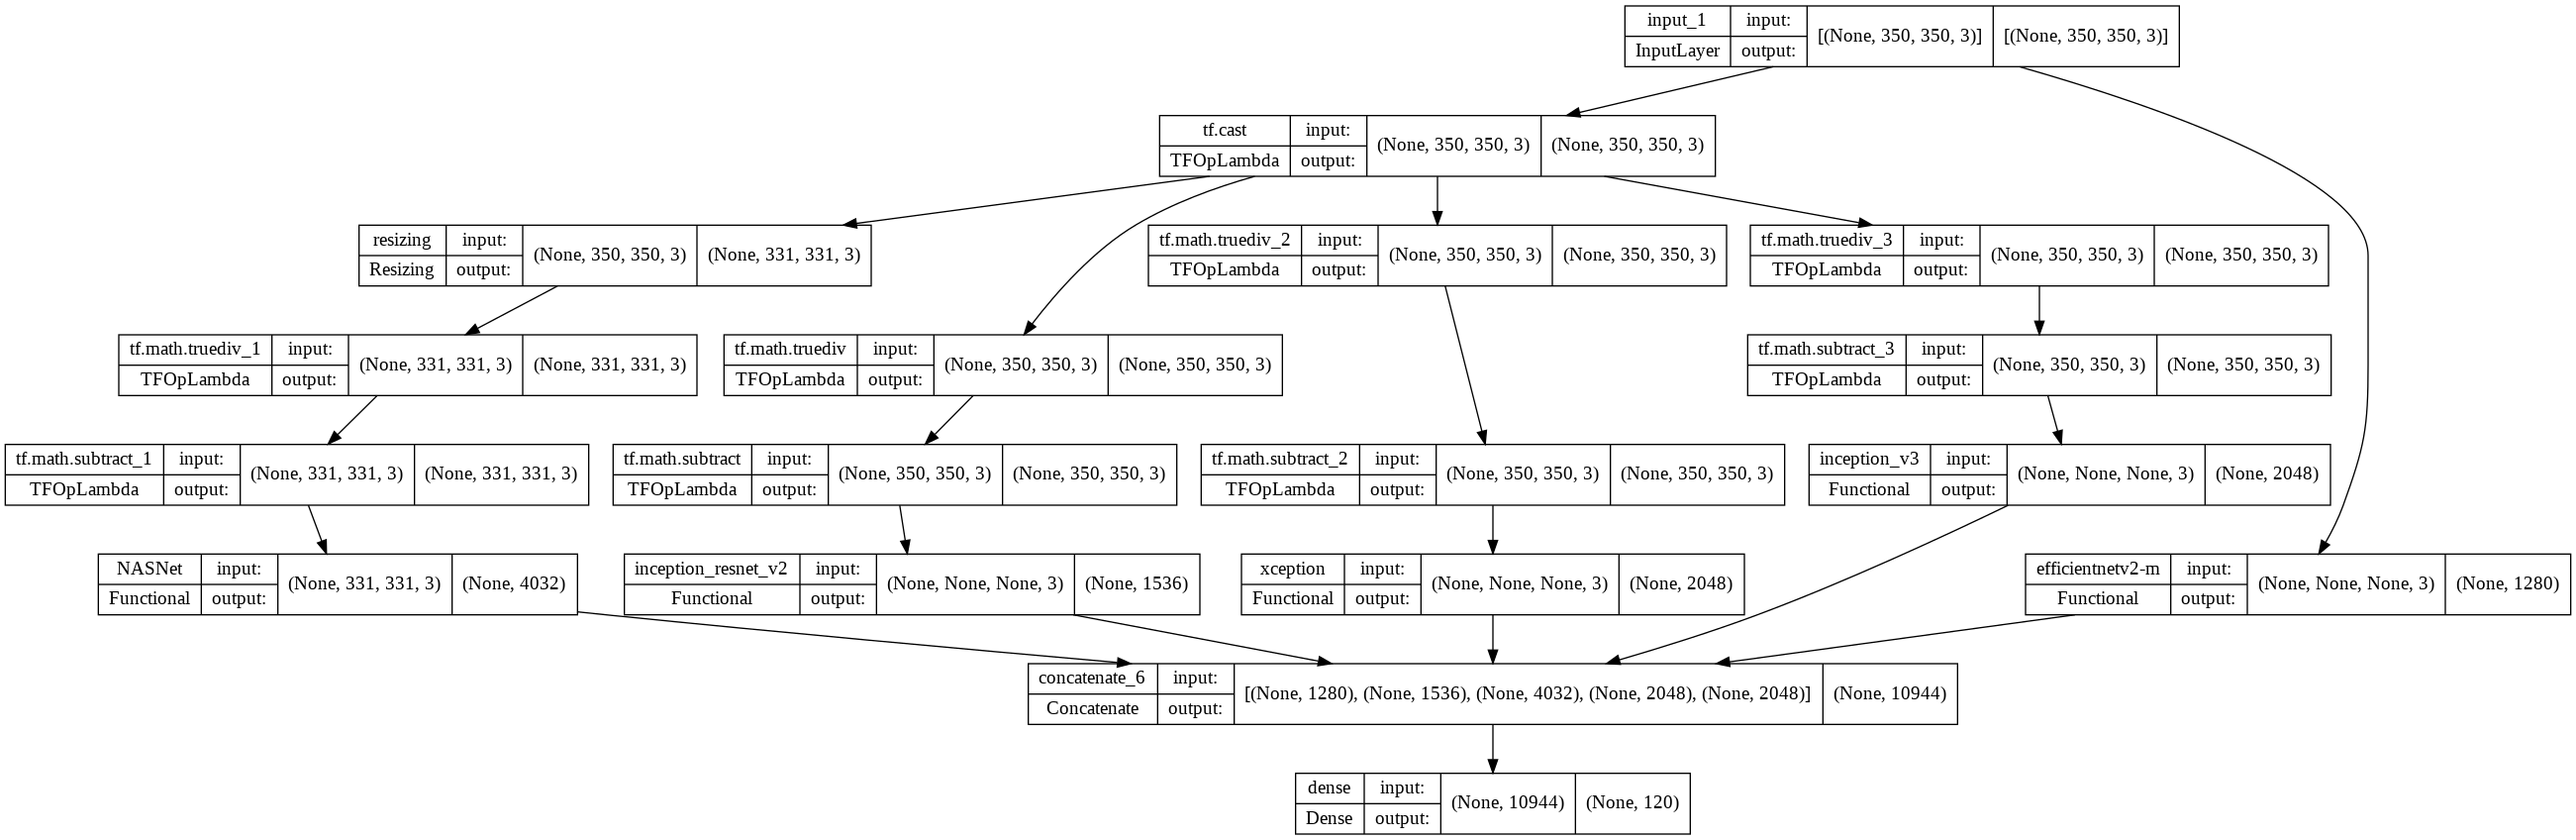

In [ ]:
tf.keras.utils.plot_model(
    ensemble_model2, to_file='ensemble_model2.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
ensemble_model2.load_weights(local_ckpt_path)

In [ ]:
test_pred = ensemble_model2.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ConvModelsEnsemble2.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


image.png

###Ensemble Model#3: Using EfficientNEt, InceptionResNet, NasNet, Xception and InceptionV3 with 50% dropout

In [ ]:
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception 
from tensorflow.keras.applications.inception_v3 import InceptionV3 

In [ ]:
def build_ensemble_model3():

  tf.keras.backend.clear_session()

  #incoming inputs
  inputs = Input(shape=(resize_height, resize_width, 3))

  #float inputs
  float_inputs = tf.cast(inputs, tf.float32)

  #resized inputs
  inputs_resized = tf.keras.layers.Resizing(331, 331)(float_inputs)

  #preprocessors
  inceptionresnet_inputs = tf.keras.applications.inception_resnet_v2.preprocess_input(float_inputs) 
  nasnet_inputs    = tf.keras.applications.nasnet.preprocess_input(inputs_resized)  
  xception_inputs  = tf.keras.applications.xception.preprocess_input(float_inputs)  
  inception_inputs = tf.keras.applications.inception_v3.preprocess_input(float_inputs)  

  #pretrained models
  effnet_base          = EfficientNetV2M(weights="imagenet", include_top=False,pooling='avg')(inputs)
  inceptionresnet_base = InceptionResNetV2(weights="imagenet", include_top=False,pooling='avg')(inceptionresnet_inputs)
  nasnet_base          = NASNetLarge(input_shape=(331,331,3),weights="imagenet", include_top=False,pooling='avg')(nasnet_inputs)
  xception_base        = Xception(weights="imagenet", include_top=False,pooling='avg')(xception_inputs)
  inception_base       = InceptionV3(weights="imagenet", include_top=False,pooling='avg')(inception_inputs)



  all_features = Concatenate()([effnet_base, inceptionresnet_base, nasnet_base,xception_base,inception_base])
  drop_features = Dropout(.5)(all_features)
  outputs = Dense(num_classes, activation='softmax')(drop_features)
  model = Model(inputs, outputs)

  return model

In [ ]:
ensemble_model3 = build_ensemble_model3()

#set the layers of the resnet pretrained model as non-trainable
for layer in ensemble_model3.layers[11].layers:  
  layer.trainable = False

for layer in ensemble_model3.layers[12].layers:   
  layer.trainable = False

for layer in ensemble_model3.layers[13].layers:   
  layer.trainable = False

for layer in ensemble_model3.layers[14].layers:   
  layer.trainable = False

for layer in ensemble_model3.layers[15].layers:   
  layer.trainable = False

#compile the model

ensemble_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(ensemble_model3.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 350, 350, 3)  0           ['input_1[0][0]']                
                                                                                                  
 resizing (Resizing)            (None, 331, 331, 3)  0           ['tf.cast[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 350, 350, 3)  0           ['tf.cast[0][0]']            

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble3"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble3"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble3"
local_ckpt_path = os.path.join(checkpoint_dir, 'ensemble3.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'ensemble3', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1,mode='min')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = ensemble_model3.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.6740 - accuracy: 0.5851
Epoch 1: val_loss improved from inf to 0.87905, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble3/ensemble3.h5
255/255 [==============================] - 647s 2s/step - loss: 2.6740 - accuracy: 0.5851 - val_loss: 0.8791 - val_accuracy: 0.9338 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.87905 to 0.36733, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble3/ensemble3.h5
255/255 [==============================] - 580s 2s/step - loss: 0.8454 - accuracy: 0.8450 - val_loss: 0.3673 - val_accuracy: 0.9402 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.8687
Epoc

In [ ]:
tf.keras.utils.plot_model(
    ensemble_model3, to_file='ensemble_model3.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
ensemble_model3.load_weights(local_ckpt_path)

In [ ]:
test_pred = ensemble_model3.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ConvModelsEnsemble3.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


image.png

###Ensemble Model#4: Using various architectures of EfficientNEt models with 50% dropout

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L

In [ ]:
def build_ensemble_model4():

  tf.keras.backend.clear_session()

  #incoming inputs
  inputs = Input(shape=(resize_height, resize_width, 3))

  #pretrained models
  effnet_base1          = EfficientNetV2B0(weights="imagenet", include_top=False,pooling='avg')(inputs)
  effnet_base2          = EfficientNetV2B3(weights="imagenet", include_top=False,pooling='avg')(inputs)
  effnet_base3          = EfficientNetV2S(weights="imagenet", include_top=False,pooling='avg')(inputs)
  effnet_base4          = EfficientNetV2M(weights="imagenet", include_top=False,pooling='avg')(inputs)
  effnet_base5          = EfficientNetV2L(weights="imagenet", include_top=False,pooling='avg')(inputs)

  all_features = Concatenate()([effnet_base1, effnet_base2, effnet_base3,effnet_base4,effnet_base5])
  drop_features = Dropout(.5)(all_features)
  outputs = Dense(num_classes, activation='softmax')(drop_features)
  model = Model(inputs, outputs)

  return model

In [ ]:
ensemble_model4 = build_ensemble_model4()

#set the layers of the resnet pretrained model as non-trainable
for layer in ensemble_model4.layers[1].layers:  
  layer.trainable = False

for layer in ensemble_model4.layers[2].layers:   
  layer.trainable = False

for layer in ensemble_model4.layers[3].layers:   
  layer.trainable = False

for layer in ensemble_model4.layers[4].layers:   
  layer.trainable = False

for layer in ensemble_model4.layers[5].layers:   
  layer.trainable = False

#compile the model

ensemble_model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(ensemble_model4.summary())

473186304/473176280 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-b0 (Functional)  (None, 1280)        5919312     ['input_1[0][0]']                
                                                                                                  
 efficientnetv2-b3 (Functional)  (None, 1536)        12930622    ['input_1[0][0]']                
                                                                                                  
 efficientnetv2-s (Function

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble4"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble4"

In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble4"
local_ckpt_path = os.path.join(checkpoint_dir, 'ensemble4.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'ensemble4', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1,mode='min')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = ensemble_model4.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 2.8832 - accuracy: 0.5931
Epoch 1: val_loss improved from inf to 1.13551, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble4/ensemble4.h5
255/255 [==============================] - 638s 2s/step - loss: 2.8832 - accuracy: 0.5931 - val_loss: 1.1355 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 0.8607 - accuracy: 0.8852
Epoch 2: val_loss improved from 1.13551 to 0.40914, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_ensemble4/ensemble4.h5
255/255 [==============================] - 515s 2s/step - loss: 0.8607 - accuracy: 0.8852 - val_loss: 0.4091 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.9078
Epoc

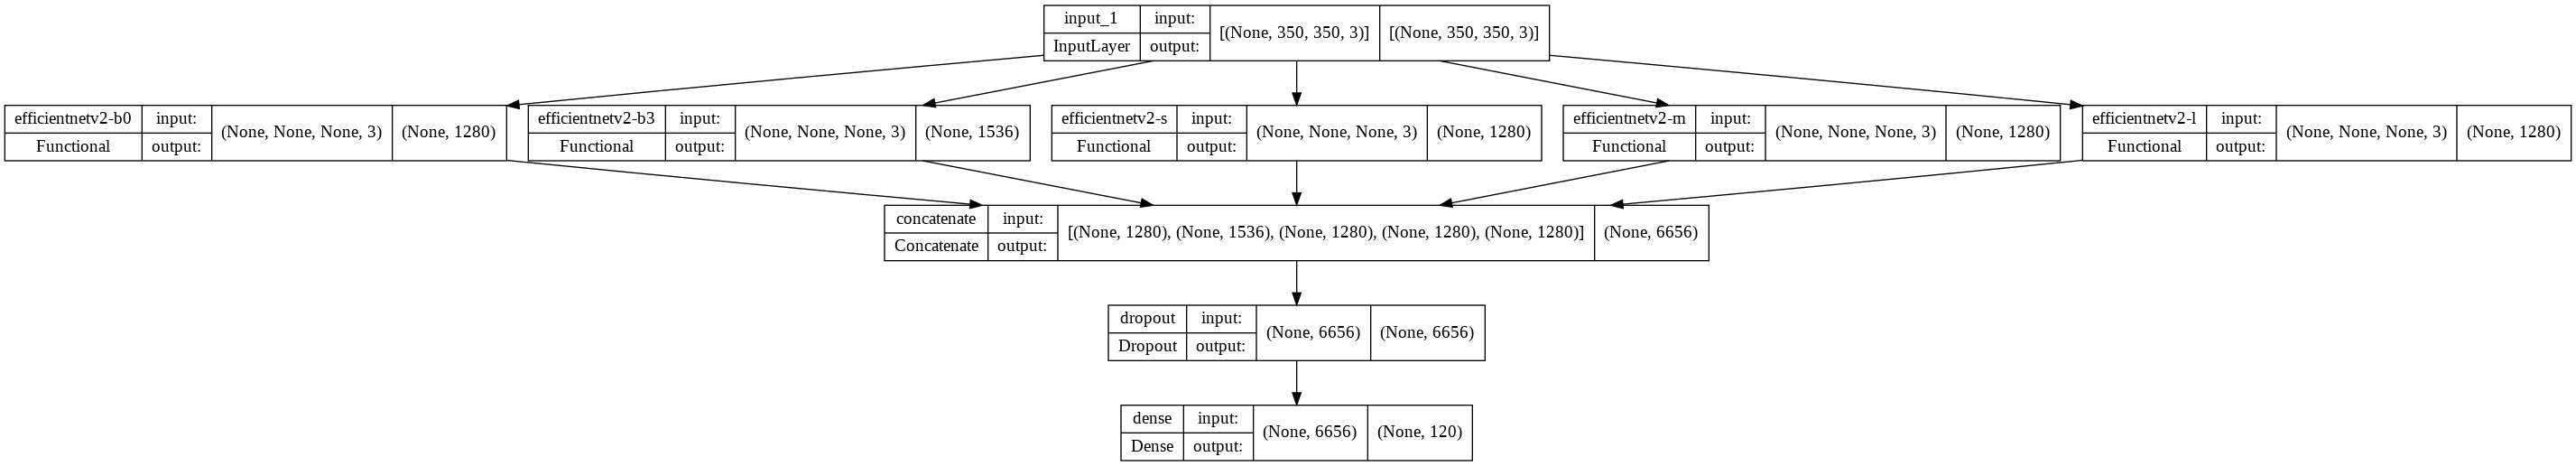

In [ ]:
tf.keras.utils.plot_model(
    ensemble_model4, to_file='ensemble_model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
ensemble_model4.load_weights(local_ckpt_path)

In [ ]:
test_pred = ensemble_model4.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_EfficientNetEnsemble.csv")

(10357, 120)

image.png

###Summary of All Experiments tried in this notebook

Training outcomes of the models

In [ ]:
modelTable = PrettyTable(["Model Name", "Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["EfficientNetV2M",  "89.64%", "93.53%", "0.38", "0.28"])
modelTable.add_row(["Inception ResNet", "82.41%", "92.65%", "0.62", "0.28"])
modelTable.add_row(["NasNet", "85.84%", "92.30%", "0.53", "0.31"])
modelTable.add_row(["Xception", "83.75%", "89.22%", "0.58", "0.36"])
modelTable.add_row(["Inception_V3", "67.50%", "87.60%", "1.31", "0.48"])
modelTable.add_row(["EfficientNetV2M_GlobalAveg", "89.40%", "94.26%", "0.64", "0.5"])
modelTable.add_row(["InceptionV3_GlobalAveg", "78.58%", "90.49%", "0.88", "0.45"])
modelTable.add_row(["EfficientNEt,InceptionResNet,NasNet,Xception", "92.4%", "94.66%", "0.262", "0.173"])
modelTable.add_row(["EfficientNEt, InceptionResNet, NasNet, Xception and InceptionV3", "94.33%", "94.26%", "0.182", "0.192"])
modelTable.add_row(["50% dropout EfficientNEt, InceptionResNet, NasNet, Xception and InceptionV3", "93.25%", "94.75%", "0.218", "0.187"])
modelTable.add_row(["50% dropout EfficientNetV2B0, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L", "95.44%", "94.71%", "0.156", "0.179"])
print(modelTable)

Print Kaggle Scores of all models tried in this notebook

In [ ]:

kaggleTable = PrettyTable(["Model Name", "KaggleScore"])
kaggleTable.add_row(["EfficientNetV2M",  "0.28347"])
kaggleTable.add_row(["Inception ResNet", "0.28623"])
kaggleTable.add_row(["NasNetLarge", "0.33285"])
kaggleTable.add_row(["Xception", "0.34187"])
kaggleTable.add_row(["Inception_V3", "0.54297"])
kaggleTable.add_row(["EfficientNetV2M_GlobalAveg", "0.50423"])
kaggleTable.add_row(["InceptionV3_GlobalAveg", "0.46402"])

kaggleTable.add_row(["ConvModelsEnsemble1 (EfficientNEt,InceptionResNet,NasNet,Xception)","0.17363"])
kaggleTable.add_row(["ConvModelsEnsemble2","0.16914"])
kaggleTable.add_row(["ConvModelsEnsemble3","0.16678"])
kaggleTable.add_row(["EfficientNetEnsemble","0.16519"])
print(kaggleTable)

+--------------------------------------------------------------------+-------------+
|                             Model Name                             | KaggleScore |
+--------------------------------------------------------------------+-------------+
|                          EfficientNetV2M                           |   0.28347   |
|                          Inception ResNet                          |   0.28623   |
|                            NasNetLarge                             |   0.33285   |
|                              Xception                              |   0.34187   |
|                            Inception_V3                            |   0.54297   |
|                     EfficientNetV2M_GlobalAveg                     |   0.50423   |
|                       InceptionV3_GlobalAveg                       |   0.46402   |
| ConvModelsEnsemble1 (EfficientNEt,InceptionResNet,NasNet,Xception) |   0.17363   |
|                        ConvModelsEnsemble2                     

###Conclusions from the Experiments

1. Ensemble of Efficient Models performs the best on the dog breed dataset.
2. EfficientNet models also trains quickly compared to the other models

##Predict on train dataset and calculate metrics

In [ ]:
shutil.rmtree("test_cache")
os.makedirs("test_cache")

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(load_images_test,num_parallel_calls=AUTOTUNE)
train_ds  = configure_for_performance(train_ds, istrain=False, istest=True)
train_pred = ensemble_model4.predict(train_ds,batch_size=32)
train_pred.shape

(8159, 120)

In [ ]:
train_pred_df = pd.DataFrame()
train_pred_df["path"] = train_paths 
train_pred_df["path"] = train_pred_df["path"].str.split('/').str[3].str.split('.jpg').str[0]

In [ ]:
shutil.rmtree("test_cache")
os.makedirs("test_cache")
train_ds  = tf.data.Dataset.from_tensor_slices((train_paths,train_label))
train_ds  = train_ds.map(load_images,num_parallel_calls=AUTOTUNE)
train_ds  = configure_for_performance(train_ds, istrain=False, istest=True)
train_out = resnet_model.evaluate(train_ds)
print("Multi-log loss is",train_out[0])

255/255 [==============================] - 65s 255ms/step - loss: 0.3460 - accuracy: 0.9118
Multi-log loss is 0.3460470736026764


In [ ]:
# 1. Identify the class with the maximum probability

#Convert one-hot vector to integer variable
train_pred_label = np.argmax(train_pred, axis=1)
train_pred_label_arr = train_pred_label
train_pred_df["pred_breed_id"] = train_pred_label_arr

#Convert integer variable to categorical variable
train_pred_df["pred_breed"] =  train_pred_df["pred_breed_id"].map(unique_breeds_reversemap)


# 2. Populate the probabilities for all classes to the dataframe
out_cols = list(unique_breeds_reversemap.values())
train_pred_df[out_cols] = train_pred

y_pred = train_pred_df["pred_breed_id"].values

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


##Metrics Calculation using the EfficientNet ensemble model

###Confusion Matrix

In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred
conf_matrix = confusion_matrix(train_label, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
conf_matrix_df = pd.DataFrame(conf_matrix, index = out_cols, columns = out_cols)

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(120,120))
sns.heatmap(conf_matrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Since the above confusion matrix is difficult to view (scrolling left-right and top-bottom), top misclassifications are extracted from the confusion matrix

In [ ]:
conf_matrix_df.reset_index(inplace=True)
conf_matrix_df.rename(columns={"index":"breed"},inplace=True)
conf_matrix_new = pd.melt(conf_matrix_df, id_vars =['breed'], value_vars =list(conf_matrix_df.columns))
conf_matrix_new.rename(columns={"variable":"misclassified_breed"},inplace=True)
conf_matrix_new.sort_values(by="value",ascending=False,inplace=True)
conf_matrix_new = conf_matrix_new.loc[conf_matrix_new["breed"]!= conf_matrix_new["misclassified_breed"]]
conf_matrix_new.head(10)

breed        misclassified_breed  value
10758                      eskimo_dog             siberian_husky     26
6415                           collie              border_collie     17
1287                 english_foxhound               walker_hound      9
5900               standard_schnauzer        miniature_schnauzer      8
3944                 miniature_poodle                 toy_poodle      7
13030                        cardigan                   pembroke      7
9488               scottish_deerhound            irish_wolfhound      6
1934          wire-haired_fox_terrier           lakeland_terrier      6
5295                          redbone        rhodesian_ridgeback      5
10388  american_staffordshire_terrier  staffordshire_bullterrier      5

Inferences from Confusion Matrix

1. 26 eskimo_dog is misclassified as siberian_husky.

2. 17 collie is misclassified as border_collie.

3. 9 english_foxhound is misclassified as walker_hound.

4. 8 standard_schnauzer is misclassified as miniature_schnauzer.


###ROC-AUC scores & Classification Report

In [ ]:
from keras.utils.np_utils import to_categorical   
train_categorical_true = to_categorical(train_label, num_classes=120)

In [ ]:
train_categorical_true.shape

(8159, 120)

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(train_categorical_true, train_pred, multi_class="ovr", average="macro"))

0.9999019044068909


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(train_label, y_pred, target_names=out_cols))

                                precision    recall  f1-score   support

                   boston_bull       0.97      0.99      0.98        70
                         dingo       0.95      0.95      0.95        64
                      pekinese       1.00      0.97      0.98        60
                      bluetick       0.99      1.00      0.99        68
              golden_retriever       0.98      0.94      0.96        53
            bedlington_terrier       1.00      1.00      1.00        71
                        borzoi       0.98      1.00      0.99        60
                       basenji       0.99      1.00      0.99        88
            scottish_deerhound       0.99      0.93      0.96       101
             shetland_sheepdog       0.97      0.97      0.97        61
                  walker_hound       0.84      0.95      0.89        55
                   maltese_dog       0.97      0.94      0.95        93
               norfolk_terrier       0.95      0.92      0.94  

Classification Metrics using Efficient Net models

* Macro Precision = 0.97
* Macro Recall    = 0.96
* Macro F1 Score  = 0.96